# Exploring the Press Data
## 2.5) Statistics on the Articles

In [21]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import spacy
from spacy import displacy

import pprint
import json
import bson

Set pandas to display 150 rows of a table by default, if it can.

In [22]:
pd.set_option("display.max_rows", 150)

### a) Some Descriptive Statistics and Tables

Import the cleaned articles dictionary

(Convert this to BSON for possible integration with MongoDB)

In [23]:
# dictionary to store the program-article dictionary
results = dict()

# import function needed to convert BSON into JSON
from bson.json_util import loads

# import the dictionary of the cleaned articles, and convert JSON into BSON
with open('./data/cleaned_articles_dictionary.json') as json_file:
    data = json.load(json_file)
    results_json = data['cleaned_articles_dictionary']

    # convert the list of JSON articles into BSON
    for program in results_json:
        results[program] = []
        for article in results_json[program]:
            results[program].append(loads(article))

Format the data into a spreadsheet/data frame

In [24]:
# create the Data Frame using a list of dictionarys
data = []

for program in results:
    
    matching_articles = results[program]

    # if the number of matching articles is zero, add a blank row for that program
    if len(matching_articles) == 0:
        entry = dict()
        entry['Program'] = program
        
        data.append(entry)
        continue

    # for each article mentioning the program stream, add a row into the table for that article
    for article in matching_articles:
        entry = dict()
        entry['Program'] = program
        entry['Department'] = article['department']
        entry['Article'] = article['title']
        entry['News Type'] = article['com_type']
        entry['Publication Date'] = article['pub_date']
        entry['Object ID'] = article['_id']

        data.append(entry)

# create the DataFrame
df = pd.DataFrame(data)

Create a table counting the number of articles, departments, publication dates, etc. for each Program Stream

In [26]:
summary_df = df.groupby(['Program']).nunique().rename(columns={"Department": "Number of Departments", "Article": "Number of Distinct Article Titles", "Object ID": "Number of Articles"}).drop(columns=['Program'])

Display the number of departments and articles mentionning each Program Stream

In [46]:
summary_df[['Number of Departments', 'Number of Articles']]

In [47]:
# How many times each program is mentionned by each department
df.fillna(value={'Department':"N/A"}).groupby(['Program', 'Department']).nunique().drop(columns=['Program', 'Department']).rename(columns={"Article":"Number of Distinct Article Titles", "Object ID": "Number of Articles"}).head(100)

Mean number of departments mentionning a program: 1.7291666666666667
Median number of departments mentionning a program: 1.0


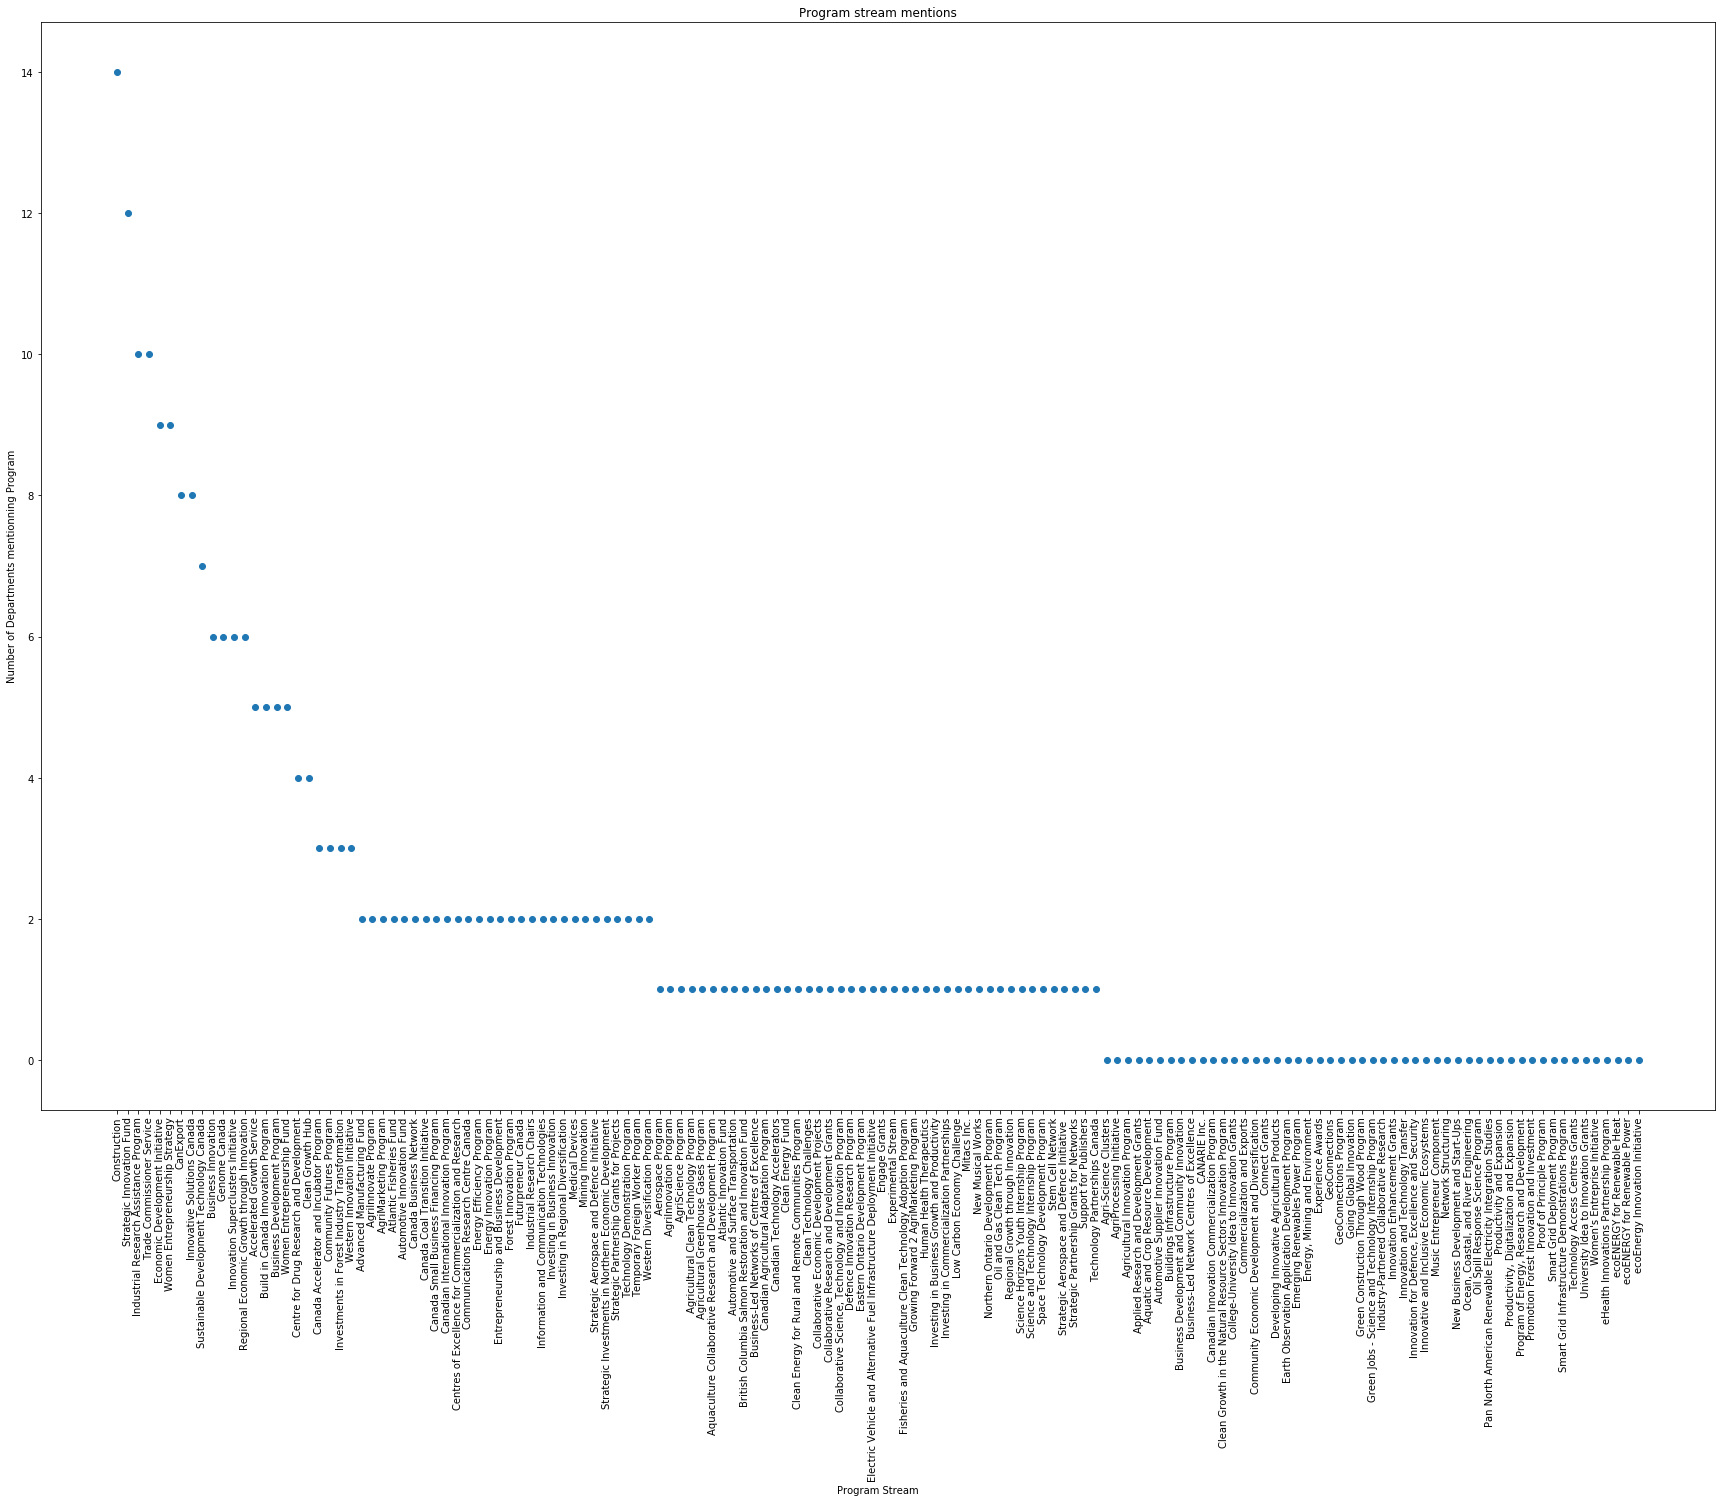

In [48]:
# Plotting the number of departments that mentionned each program
%matplotlib inline
summary_df_sorted = summary_df.reset_index().sort_values(by=['Number of Departments', 'Program'], ascending=[False, True])
plt.figure(figsize = (30,20))
plt.xticks(rotation='vertical')
plt.title("Program stream mentions")
plt.xlabel("Program Stream")
plt.ylabel("Number of Departments mentionning Program")
plt.scatter(summary_df_sorted['Program'], summary_df_sorted['Number of Departments'])
print("Mean number of departments mentionning a program:", summary_df['Number of Departments'].mean())
print("Median number of departments mentionning a program:", summary_df['Number of Departments'].median())

In [49]:
# Showing how many programs each department mentionned
summary_by_dept_df = df.groupby("Department").nunique().drop(columns=["Department"]).rename(columns={"Program":"Number of Programs", "Object ID":"Number of Articles", "Article":"Number of Distinct Article Titles"}).sort_values(by=["Number of Programs"], ascending=[False])
print("Mean number of programs mentionned per department:", summary_by_dept_df['Number of Programs'].mean())
print("Median number of programs mentionned per department:", summary_by_dept_df['Number of Programs'].median())
summary_by_dept_df

Mean number of programs mentionned per department: 13.833333333333334
Median number of programs mentionned per department: 13.0


In [50]:
# Display which Program Streams are mentionned by the departments, and how many times
df[['Department', 'Program', 'Object ID']].groupby(['Department', 'Program']).count().rename(columns={"Object ID": "Number of Articles"}).head(150)

In [51]:
# Display which Program Streams are not mentionned by any of the articles
zero_mentions_programs = summary_df.loc[summary_df['Number of Articles'] == 0].reset_index()['Program']
zero_mentions_programs

In [52]:
# Only looking at the Program Streams that are mentionned
df = df.dropna(subset=["Object ID"])

### b) Counting Words in the Articles

Use spaCy to determine the most frequently occuring (and non-trivial) words amongst all the articles

Import the list of cleaned articles

In [53]:
# list to store the cleaned articles
cleaned_articles = list()

# import the list of cleaned articles
with open('./data/cleaned_articles.json') as json_file:
    # load the file as a JSON object
    data = json.load(json_file)
    
    # get the list of articles
    results_json = data['cleaned_articles']
    
    # convert the JSON into BSON
    for article in results_json:
        cleaned_articles.append(loads(article))

Load spaCy's basic English model.

Modify it to add more stop words such as "Canada", "Government", and other frequently occuring but uninteresting words.

In [54]:
# load spaCy's basic English model
nlp = spacy.load("en_core_web_sm")

# add additional uninteresting words to spaCy's stop-words list
# these are additional words spaCy will ignore when do the word count
# note: adding new stop words have to be in lower case, even if the word is normally capitalized (ex. canada)
additional_stop_words = {"$", "|", 'canada', 'canadians', 'canadian', 'minister', 'honourable', 'government', 'federal'}
nlp.Defaults.stop_words |= additional_stop_words

Run spaCy's Natural Language Processor to count non-trivial words

In [55]:
# create a dictionary to count the words in the articles
word_dict = dict()

# Keep a counter to track progress
i = 0

# tally the words in the articles and store the results in the dictionary
for article in cleaned_articles:  
    article = cleaned_articles[i]
    
    # get the text portion of the article
    text = article['details']['fulltext']
    
    i += 1
    # print statment to track progress
    if i % 250 == 0:
        print("Finished processing", i, "articles")
    
    # apply the nlp to each paragraph in the article
    # the tagger, parser, and ner are diasabled to allow for faster processing
    for doc in nlp.pipe(text, disable = ["tagger", "parser", "ner"]):
        for token in doc:
            if token.is_stop or token.is_punct:
                continue
            word = token.text.lower()
            if word in word_dict:
                word_dict[word] += 1
            else:
                word_dict[word] = 1

KeyboardInterrupt: 

Visualizing the data

In [ ]:
# store results in a Data Frame, and show first 150 most frequent words
word_counts = pd.DataFrame(word_dict.items(), columns=["Word", "Count"])
word_counts = word_counts.sort_values(by=["Count", "Word"], ascending=[False, True])
word_counts.head(150)

In [ ]:
# Plotting the 50 most frequent words in the articles
top_50_words = word_counts.sort_values(by=["Count", "Word"], ascending=[False, True]).head(50)
%matplotlib inline
plt.figure(figsize = (30,20))
plt.xticks(rotation='vertical')
plt.title("Most frequent words")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.scatter(top_50_words["Word"], top_50_words["Count"])